In [1]:
!pip install laserembeddings
!python -m laserembeddings download-models

     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 860kB 7.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=6fa279efad4c9094f18cc229d9b25f0b928a49c84e137d9659b92c7c4d863206
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses

✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!


In [2]:
import pandas as pd
import numpy as np
import laserembeddings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#In order to compare, use the same preprocessed data we created in the word2vec notebook
df_preprocessed = pd.read_csv('gdrive/My Drive/reddit_preprocessed.csv')
df_grouped = pd.read_csv('gdrive/My Drive/reddit_grouped.csv')

In [0]:
#This will take a while to run!
from laserembeddings import Laser

laser = Laser()

author_vectors = [laser.embed_sentences([text], lang='en') for text in df_grouped.title]

In [0]:
author_vectors = [np.concatenate(x) for x in author_vectors]

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(author_vectors)

df_grouped['tsne_x'] = tsne_results[:,0]
df_grouped['tsne_y'] = tsne_results[:,1]

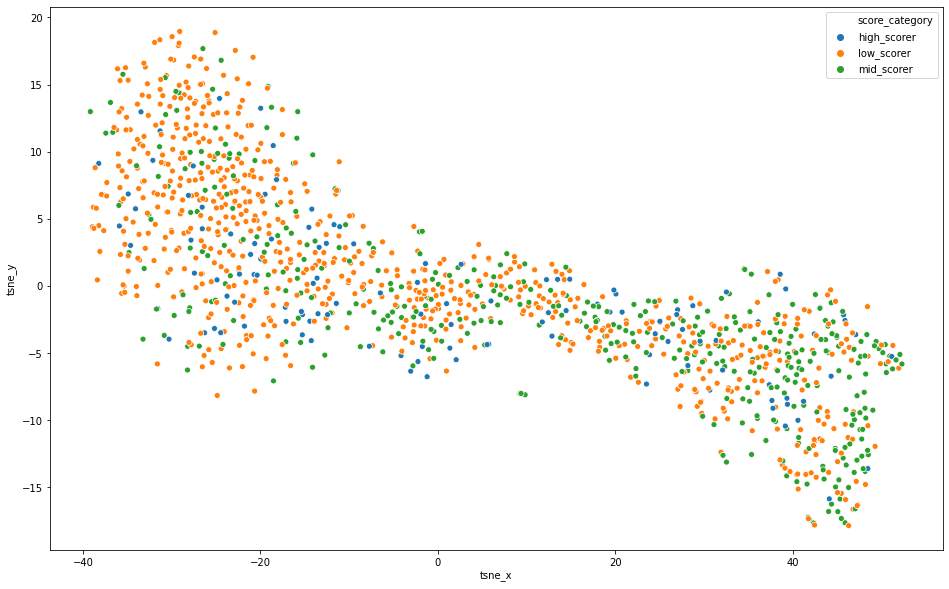

In [8]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne_x', y='tsne_y',
    hue="score_category",
    data=df_grouped,
    legend="full")

Since we have 3 or 4 clear clusters here, k-means clustering might be helpful.

In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0).fit(np.array(author_vectors))
df_grouped['cluster'] = kmeans.labels_

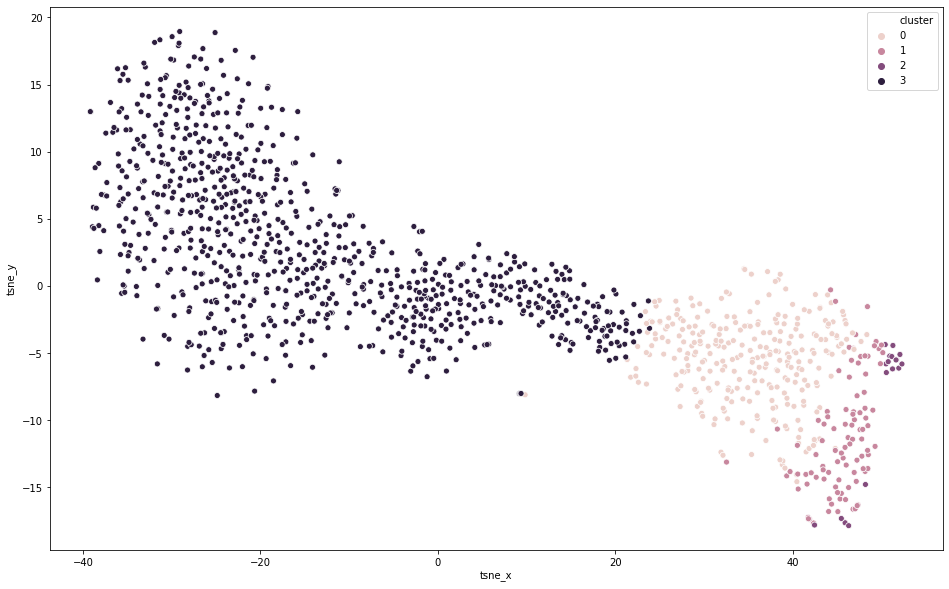

In [11]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne_x', y='tsne_y',
    hue="cluster",
    data=df_grouped,
    legend="full")

In [0]:
from sklearn.metrics.pairwise import cosine_distances

author_distances = pd.DataFrame(
    cosine_distances(author_vectors, author_vectors)
)

author_distances_v2 = author_distances.replace(0, np.nan)

In [18]:
pd.set_option('display.max_colwidth', 100)

most_similar_cosine = pd.DataFrame()

for i, row in author_distances_v2.head().iterrows():
  most_similar = np.argsort(row.values)[:4]
  most_similar_authors = []
  for s in most_similar:
    author = str(df_grouped.author[s])
    most_similar_authors.append(author)
  most_similar_i = pd.DataFrame({'original':df_grouped.author[i], 'most_similar':', '.join(most_similar_authors)}, index=[0])
  most_similar_cosine = most_similar_cosine.append(most_similar_i)

most_similar_cosine

,original,most_similar
0,000078754,"dredd, pookie74, fitqueenb, downgoesfrazier"
0,007simple,"stavromullerbeta, AvicusGottskalk, matthew26, pookie74"
0,00boyina,"joelrw, cup, jimmurphysf, kcnchfan"
0,02116663ag,"sam1426, samblesj, louis_xiv42, Laserfalcon"
0,0boy,"Kyusu, Imagineti, pastr, dzneill"


In [14]:
!pip install faiss-cpu --no-cache

     |████████████████████████████████| 7.2MB 2.5MB/s 


In [15]:
import faiss      

query_vectors = author_vectors[:5]
database_vectors = author_vectors[5:]

vector_size = 1024                                      
             
index = faiss.IndexFlatL2(vector_size) 
print(index.is_trained)

True


In [16]:
database_vector = np.array(database_vectors, dtype='float32')
query_vector = np.array(query_vectors, dtype='float32')
index.add(database_vector)                 
print(index.ntotal)

1252


In [17]:
#The search method searches for the n nearest vectors to the query vector
distance, sim_index = index.search(query_vector, 4)

most_similar_faiss = pd.DataFrame()

for i in range(5):
  most_similar_authors = []
  for s in sim_index[i]:
    author = str(df_grouped.author[s])
    most_similar_authors.append(author)
  most_similar_i = pd.DataFrame({'original':df_grouped.author[i], 'most_similar':', '.join(most_similar_authors)}, index=[0])
  most_similar_faiss = most_similar_faiss.append(most_similar_i)

most_similar_faiss

,original,most_similar
0,000078754,"fellowmellow, polar, nebm, theseusastro"
0,007simple,"splunge4me2, polar, markvand, reeds1999"
0,00boyina,"jms1225, karthikmns, dulieu, NoNoLibertarians"
0,02116663ag,"sadbuttru, safishb, escape_goat, telefonbesked"
0,0boy,"dynamohum, Kleenex1, louis_xiv42, mhughes3500"
